<h1 id='Part1'>A Look at the relevant data</h1>

In order to get a better understanding of the data we will be take a closer look in the first section, highlighting features and main take aways.

First, let's read in the data and necessary libraries.

Key questions that we would like to answer:

What is the AirBnb market in Seattle looking like? 
 



In [1]:
# import all the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string as str
from adjustText import adjust_text
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
import DataPrepFunctions as dtprep
from mpl_toolkits.basemap import Basemap
from pyproj import Proj, transform
sia = SentimentIntensityAnalyzer()
df = pd.read_csv('./listings.csv')

# look into the dimensions of the DB
num_rows = df.shape[0] 
num_cols = df.shape[1]

# utils
# function to convert string into float
dollar_to_float= lambda x: x.replace('[\$,]', '', regex=True).astype(float)

# look into the type of data available 
df.dtypes.value_counts()

# display the first 5 rows
df.head(5)



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


<h3 id='Part1.1'> Property type </h3>

Taking a dive into the most common properties in the market and the most relevant features

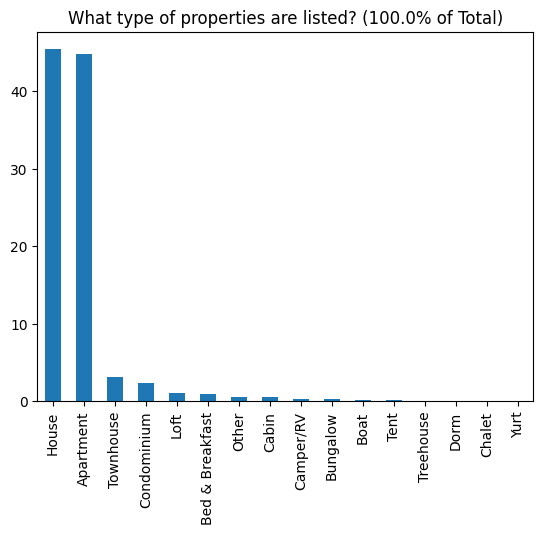

In [2]:
# Selection the columns relevant for our analysis 
prop_columns = ['property_type',"room_type","bed_type","amenities","accommodates","bathrooms","bedrooms","beds"]
df_properties = df[prop_columns]

df_properties.head(5)
# selection the top 5 properties 
df_chart = df_properties['property_type'].value_counts(normalize = True)*100
df_chart
sampleSize= np.sum(df_chart)

# plotting the type of properties
df_chart.plot(kind = "bar");
plt.title(f'What type of properties are listed? ({sampleSize}% of Total)');


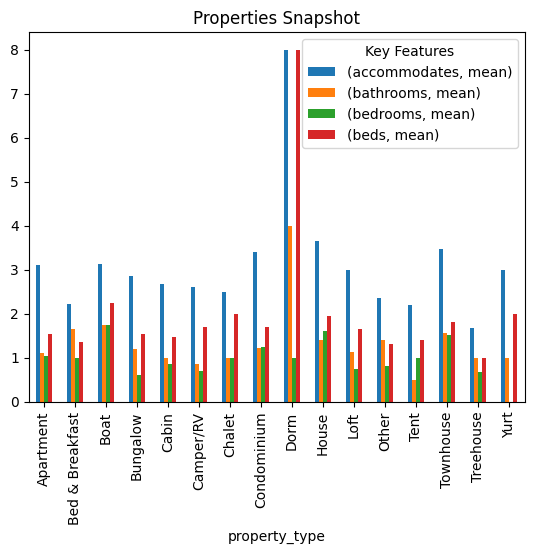

In [3]:
# Looking into the standard features of each property type
group_prop= df_properties.groupby("property_type",group_keys=True ,as_index=False)

#plot the key features of the properties
group_prop[["accommodates","bathrooms","bedrooms","beds"]].agg(["mean"]).plot(kind = "bar")
plt.title("Properties Snapshot");
plt.legend(title="Key Features")

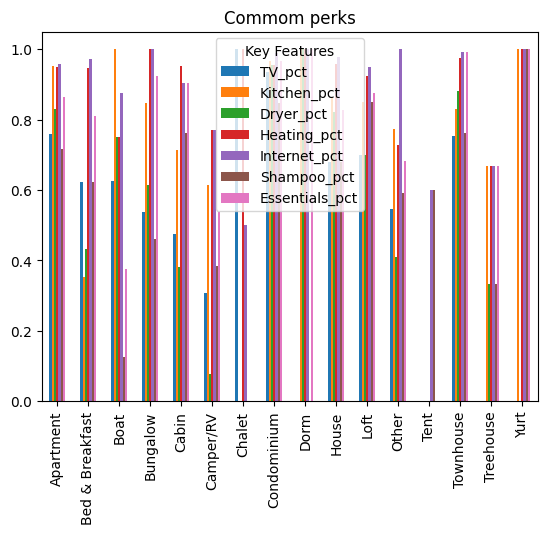

In [4]:
# What type of amenities are usually availabel witht the property
amenitis_list = []
# create the full list of available amenities and compute the percentage available for each type of properties
amenitis_list = dtprep.convert_colCont2List(df_properties,'amenities')
df_comm = dtprep.mostcommon_stuff(group_prop,df_properties,amenitis_list)

#plot the most common amenities
reduce_df_comm = df_comm.iloc[:, np.where((df_comm.median() > 0.5) == True)[0]]
reduce_df_comm.plot(kind = "bar")
plt.title("Commom perks");
plt.legend(title="Key Features")


<h3 id='Part1.2'> Location  </h3>

Looking into how the supply of properties is spread and what are the classic neighbours where to find the perfect airbnb 

Text(0.5, 1.0, 'Main Location for Seattle listings => 76.9 % of total')

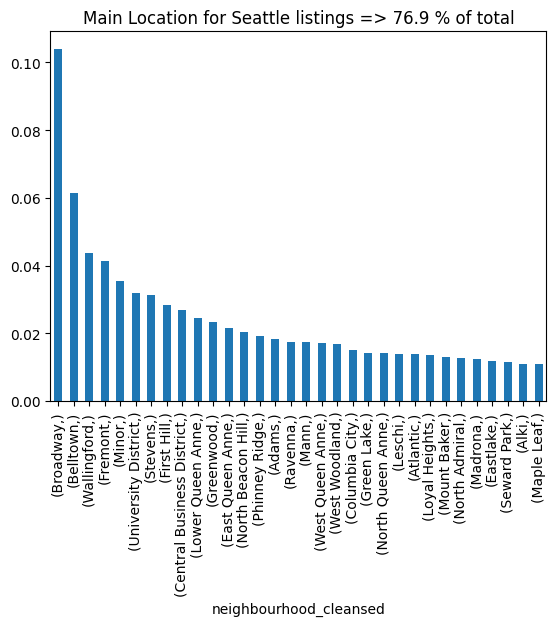

In [5]:
# granular location where the listings are located
loc_cols = ['neighbourhood_cleansed']
tot = (df
[loc_cols]
.value_counts()/df.shape[0])[(df
[loc_cols]
.value_counts()/df.shape[0])>0.01].sum()

# plot the key locations
(df
[loc_cols]
.value_counts()/df.shape[0])[(df
[loc_cols]
.value_counts()/df.shape[0])>0.01].plot(kind="bar")

plt.title(f'Main Location for Seattle listings => {np.round(tot*100,1)} % of total')
#Total sum of the neigborood with more than 1% of the listings



In [8]:
# Let's try to represent them on the map 
loc2_cols = ['neighbourhood_cleansed','latitude','longitude']	

# limits latitude
maxlat= np.max(df["latitude"])-0.03
minlat= np.min(df["latitude"])+0.04

# limits longitude
maxlong= np.max(df["longitude"])-0.02
minlong=np.min(df["longitude"])+0.02

long = 47.608013
lat = -122.335167

# creatin group for locate each different zone
dtgroup=(df
[loc2_cols]
.groupby('neighbourhood_cleansed',as_index=False)
       .agg(Lat=pd.NamedAgg(column="latitude", aggfunc=np.median),
            Long=pd.NamedAgg(column="longitude", aggfunc=np.median),
            Count=pd.NamedAgg(column="longitude", aggfunc=np.count_nonzero)))
dtgroup['Count_Pct'] = dtgroup['Count']/df.shape[0]
dtgroup = dtgroup[dtgroup['Count_Pct']>0.01].copy()

# plot
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='merc', resolution='i',
             llcrnrlon=minlong,llcrnrlat=minlat,urcrnrlon=maxlong, urcrnrlat=maxlat, epsg = 3857, lat_0= lat, lon_0 = long
             )


m.arcgisimage(service='USA_Topo_Maps', xpixels=2000, ypixels=2000, verbose= True)

m.scatter(dtgroup["Long"].values,dtgroup["Lat"].values , latlon=True,
          c=dtgroup["Count"].values, s=dtgroup["Count"].values,
          cmap='Blues', alpha=0.8)

plt.colorbar(label="# of Listings",fraction=0.025)
plt.clim(10, 250)          



ValueError: lat_0 must be between -90.000000 and 90.000000 degrees

<Figure size 1200x1200 with 0 Axes>

In [62]:
inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')
x1,y1 = -11705274.6374,4826473.6922
x2,y2 = transform(inProj,outProj,x1,y1)
print (x2,y2)

-105.15027111593008 39.72785727727918


c:\Users\eusep\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\eusep\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\eusep\AppData\Local\Temp\ipykernel_24616\2314900.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/go

<h3 id='Part1.3'> Price  </h3>

Looking into how the property are priced based on the listing price per night, week , month and the price per guest.

In [32]:
# pricing column selections
pricing_pol = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights','accommodates']
df_princing = df[pricing_pol].copy()

money_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

#pricing stats
df_princing[money_cols]=df_princing[money_cols].apply(dollar_to_float, axis=1)
df_princing['price_1_guest'] = df_princing['price']/df_princing['accommodates']
df_princing['weekly_price_DD'] = df_princing['price']*7
df_princing['monthly_price_DD'] = df_princing['price']*30
df_princing['weekly_discount'] = df_princing['weekly_price']/df_princing['weekly_price_DD']-1
df_princing['monthly_discount'] = df_princing['monthly_price']/df_princing['monthly_price_DD']-1

#discount for longer stays
m_discount = np.median(df_princing['monthly_discount'].values)
w_discount = np.median(df_princing['weekly_discount'].values)
# print of the results
df_princing.describe()




,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,accommodates,price_1_guest,weekly_price_DD,monthly_price_DD,weekly_discount,monthly_discount
count,3818.000000,2009.000000,1517.000000,1866.000000,2788.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,2009.000000,1517.000000
mean,127.976166,788.481832,2613.336190,287.610397,61.710904,1.672603,10.667627,2.369303,780.447617,3.349398,41.266923,895.833159,3839.284966,-0.069487,-0.259978
std,90.250022,532.352269,1722.267981,270.222690,48.830341,1.311040,17.585922,16.305902,1683.589007,1.977599,20.676221,631.750155,2707.500665,0.193504,0.216174
min,20.000000,100.000000,500.000000,95.000000,5.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4.750000,140.000000,600.000000,-0.625850,-0.822222
25%,75.000000,455.000000,1512.000000,150.000000,25.000000,1.000000,0.000000,1.000000,60.000000,2.000000,27.500000,525.000000,2250.000000,-0.166667,-0.377395
50%,100.000000,650.000000,2200.000000,250.000000,50.000000,1.000000,0.000000,2.000000,1125.000000,3.000000,37.500000,700.000000,3000.000000,-0.095238,-0.285714
75%,150.000000,950.000000,3150.000000,300.000000,83.000000,2.000000,20.000000,2.000000,1125.000000,4.000000,50.000000,1050.000000,4500.000000,-0.003322,-0.166667
max,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,15.000000,300.000000,1000.000000,100000.000000,16.000000,275.000000,7000.000000,30000.000000,1.428571,3.604615


In [65]:
# Combination of pricing and location
prix_cols = ["price_1_guest"]
df_pricing_loc = pd.concat([df_princing[prix_cols],df[loc2_cols]], axis = 1)

dtgroup2=(df_pricing_loc
.groupby('neighbourhood_cleansed',as_index=False)
       .agg(Lat=pd.NamedAgg(column="latitude", aggfunc=np.median),
            Long=pd.NamedAgg(column="longitude", aggfunc=np.median),
            Count=pd.NamedAgg(column="longitude", aggfunc=np.count_nonzero),
            Price=pd.NamedAgg(column="price_1_guest", aggfunc=np.mean)))
dtgroup2['Count_Pct'] = dtgroup['Count']/df.shape[0]
dtgroup2 = dtgroup2[dtgroup2['Count_Pct']>0.01].copy()


fig = plt.figure(figsize=(10,10))
m = Basemap(projection='merc', resolution='i',
             llcrnrlon=minlong,llcrnrlat=minlat,urcrnrlon=maxlong, urcrnrlat=maxlat, epsg = 3857  , lat_0= lat, lon_0 = long)

#test_map = Basemap(,resolution='i',projection='merc',lon_0=14.8,lat_0=47.2)
m.arcgisimage(service='World_Street_Map', xpixels=2000, ypixels=2000, verbose= True)
x,y = m(dtgroup2["Long"].values, dtgroup2["Lat"].values)
m.scatter(x, y,
          c=dtgroup2["Price"].values, s=dtgroup2["Count"].values,
          cmap='Blues', alpha=0.8)

plt.colorbar(label="Price per person in $",fraction=0.025 )
plt.clim(30, 60)   

for a in [30, 100, 300]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label= f'{a} listings')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#labels
for i in dtgroup2.index :
    if dtgroup2['Price'][i] : 
        x = dtgroup2['Long'][i]
        y = dtgroup2['Lat'][i]
        tx= dtgroup2['neighbourhood_cleansed'][i]
        xx, yy = m(x, y) #m is basemap object
        plt.text(xx,yy, tx, fontsize=7)

plt.savefig('Seattle.png',bbox_inches='tight',dpi=100)        
           

ValueError: lat_0 must be between -90.000000 and 90.000000 degrees

<Figure size 1000x1000 with 0 Axes>

<h3 id='Part1.4'> Existing host analysis </h3>

What are the typical features of an host in Seattle? 

C:\Users\eusep\AppData\Local\Temp\ipykernel_16420\2968913402.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['host_is_superhost'] = np.where(df['host_is_superhost']=='t',True,False)
C:\Users\eusep\AppData\Local\Temp\ipykernel_16420\2968913402.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_new.corr()


,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,calculated_host_listings_count
count,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3191.000000,3818.000000
mean,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.078919,2.946307
std,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,1.822348,5.893029
min,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.020000,1.000000
25%,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.695000,1.000000
50%,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.540000,1.000000
75%,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000,2.000000
max,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000,37.000000


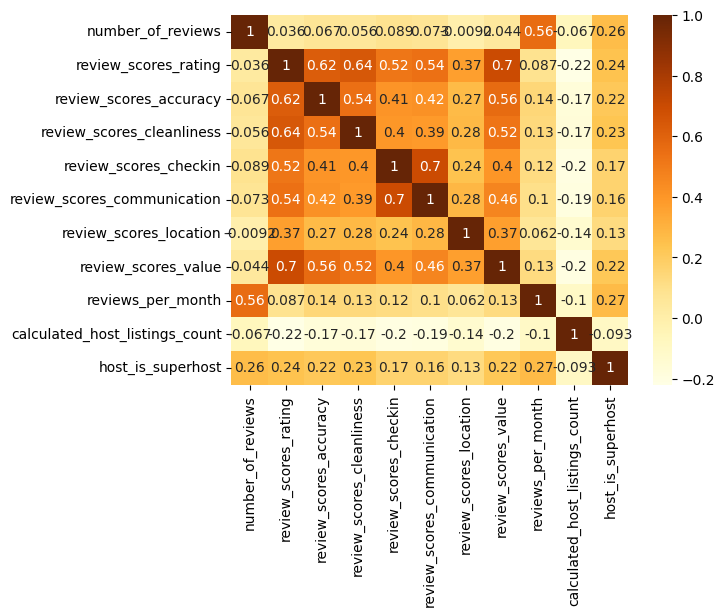

In [12]:
# host cols 
Host_cols = ['host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count']

df_new_ =  df[Host_cols]


# remove the super host transorm the data of the super host - host repsonse rate
Review_cols = ['number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
       'review_scores_location', 'review_scores_value', 'reviews_per_month','calculated_host_listings_count','host_is_superhost','host_response_rate']     

df_new = df[Review_cols]
# get the super host - status checked
df_new['host_is_superhost'] = np.where(df['host_is_superhost']=='t',True,False)
corr = df_new.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values , cmap = 'YlOrBr' , annot=True)
df_new.describe()


<h1 id='Part2'> Data preparation </h1>

Preparing the dataset before estimating the model.

<h3 id='Part2.1'> Dependent variables </h3>

Selecting the variables we want to estimate.

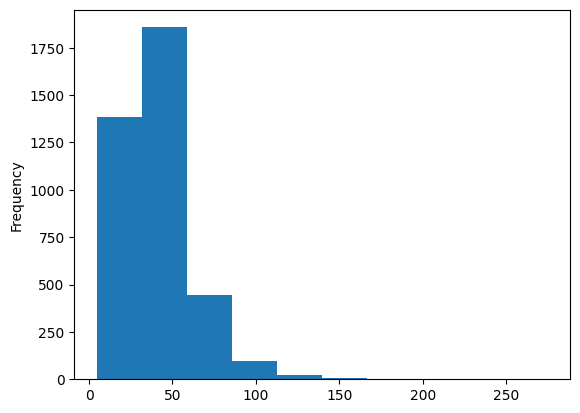

In [2]:
pricing_pol = ['price','accommodates']
df_princing = df[pricing_pol].copy()
df_princing=df_princing.apply(dollar_to_float, axis=1)
df_princing['price_1_guest'] = df_princing['price']/df_princing['accommodates']

# distribution of price per accomodate
df_princing['price_1_guest'].plot(kind='hist')

# y variable
df_princing_y = df_princing['price_1_guest'].copy()





<h3 id='Part2.2'> Indipendent variables </h3>

In [27]:
prop_columns = ["property_type","bed_type","room_type","amenities","accommodates","bathrooms","bedrooms","beds"]
loc_columns =['neighbourhood_cleansed']
review_columns = ['reviews_per_month','review_scores_rating','host_is_superhost','instant_bookable','host_response_time','last_scraped','host_since']

col_select = prop_columns + loc_columns + review_columns
#selection column
df_sel = df[col_select].copy()

# Normalise the listing features by number of accomodates
df_sel["bathrooms"] = df_sel["bathrooms"] / df_sel['accommodates']
df_sel["bedrooms"] = df_sel["bedrooms"] / df_sel['accommodates']
df_sel["beds"] = df_sel["beds"] / df_sel['accommodates']
# property type mapping
df_sel['property_type'] = df_sel['property_type'].map(
        {'House': 'House', 
         'Apartment': 'Apartment'}
    ).fillna('Other')

# Does super host help with pricing? 
df_sel['host_is_superhost'] = np.where(df_sel['host_is_superhost']=='t',True,False)
# Are rating and # of review influencing pricing?
df_sel['cx_score'] = df_sel['review_scores_rating'].astype(float)/100 * df_sel['reviews_per_month'].astype(float)

# Is host booking support relevant?
df_sel = dtprep.convert_host_response_time(df_sel)
df_sel = dtprep.convert_instant_bookable(df_sel)
df_sel = dtprep.convert_host_since(df_sel)


# convert the amenities to boolean 
df_sel= dtprep.convert_amenities(df_sel)
df_sel.replace({False: 0, True: 1}, inplace=True)


# column to drop
todrop= ["accommodates","reviews_per_month","review_scores_rating",'host_since']

# taking care of NAs
df_sel = dtprep.clean_data_basic(df_sel,todrop)

# drop some cols 
df_sel = df_sel.drop(['room_type_Private room', 'room_type_Shared room'],axis = 1)
df_sel

c:\Users\eusep\OneDrive\Documenti\GitHub\AirBnB_Project\DataPrepFunctions.py:371: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['amenities_dogs'] = df['amenities'].str.contains('Dog(s)')
c:\Users\eusep\OneDrive\Documenti\GitHub\AirBnB_Project\DataPrepFunctions.py:373: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['amenities_cats'] = df['amenities'].str.contains('Cat(s)')
c:\Users\eusep\OneDrive\Documenti\GitHub\AirBnB_Project\DataPrepFunctions.py:383: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['amenities_other_pets'] = df['amenities'].str.contains('Other pet(s)')


,bathrooms,bedrooms,beds,host_is_superhost,instant_bookable,host_response_time,cx_score,days_as_host,amenities_tv,amenities_internet,...,neighbourhood_cleansed_Victory Heights,neighbourhood_cleansed_View Ridge,neighbourhood_cleansed_Wallingford,neighbourhood_cleansed_Wedgwood,neighbourhood_cleansed_West Queen Anne,neighbourhood_cleansed_West Woodland,neighbourhood_cleansed_Westlake,neighbourhood_cleansed_Whittier Heights,neighbourhood_cleansed_Windermere,neighbourhood_cleansed_Yesler Terrace
0,0.250000,0.250000,0.250000,0,0.0,2.0,3.8665,1607.0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,0.250000,0.250000,0.250000,1,0.0,1.0,1.4208,1047.0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,0.409091,0.454545,0.636364,0,0.0,2.0,1.1155,571.0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,0.333333,0.000000,0.666667,0,0.0,4.0,1.4784,789.0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.333333,0.500000,0.500000,0,0.0,1.0,0.8188,1497.0,1,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.333333,0.500000,0.500000,0,0.0,2.0,0.2400,266.0,1,1,...,0,0,0,0,0,0,0,0,0,0
3814,0.250000,0.250000,0.500000,0,0.0,1.0,2.0000,82.0,1,1,...,0,0,0,0,0,0,0,0,0,0
3815,0.500000,0.500000,0.500000,0,0.0,4.0,1.4784,5.0,1,1,...,0,0,0,0,0,0,0,0,0,0
3816,0.500000,0.000000,0.500000,0,0.0,1.0,1.4784,366.0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_sel.filter(regex='property').describe()

,amenities_pets_live_on_this_property,property_type_Apartment,property_type_House,property_type_Other
count,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.231273,0.447355,0.453903,0.098743
std,0.421702,0.497286,0.497936,0.298355
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


<h1 id='Part3'> Model Estimation </h1>

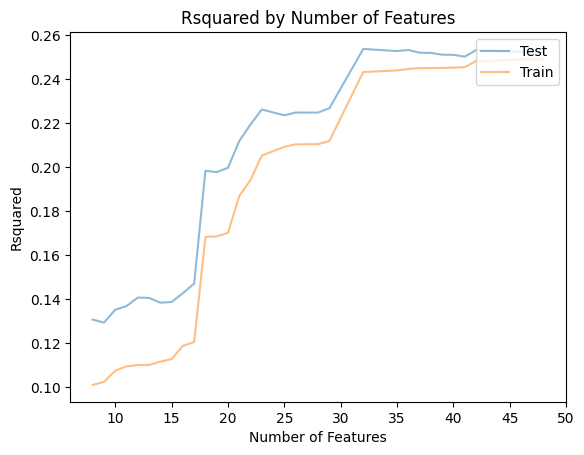

In [32]:
cutoffs = range(5,96,1)

X = df_sel
y = df_princing_y
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test, dynam = dtprep.find_optimal_lm_mod(X, y, cutoffs, test_size = .25, norm = True, random_state = 200)


In [33]:
#extract coefficients
coef_df = dtprep.coef_weights(lm_model=lm_model,X_train= X_train)
chart = coef_df[['est_int','coefs','abs_coefs']].style.bar(subset=['coefs'], align='mid', color=['#d65f5f', '#5fba7d']) 
chart
   

,est_int,coefs,abs_coefs
31,room_type_Entire home/apt,5.067100,5.067100
1,bedrooms,4.263712,4.263712
0,bathrooms,4.100413,4.100413
12,amenities_elevator_in_building,3.188901,3.188901
4,host_response_time,3.187168,3.187168
29,property_type_House,-3.182980,3.182980
3,host_is_superhost,2.455094,2.455094
28,property_type_Apartment,-2.374407,2.374407
21,amenities_family_kid_friendly,-1.802853,1.802853
14,amenities_free_parking_on_premises,-1.708645,1.708645


In [9]:
lm_model.named_steps['clf'].coef_

KeyError: 'clf'

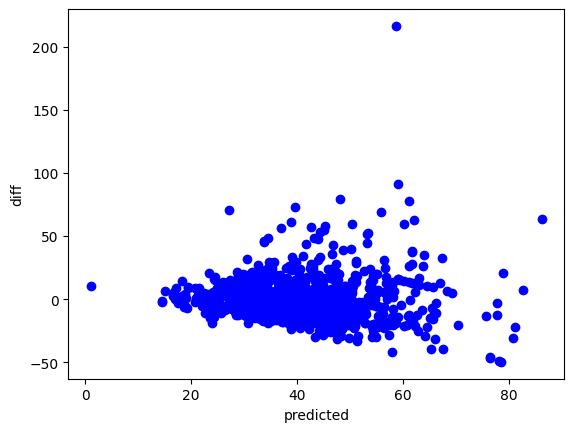

In [34]:
y_test_preds = lm_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('diff');
